# Compare the predictions of the Img and Img+bbox models
- comparison using same images for following cases:
1.	‘img’ and ‘img+bbox’ models both predict same correct class (y_pred,img = y_pred,img+bbox == y_true)
2.	‘img’ and ‘img+bbox’ models both predict same incorrect class (y_pred,img = y_pred,img+bbox != y¬true)
3.	‘img’ model predicts correct class; ‘img+bbox’ model predict incorrect class (y_pred,img == y_true && y_pred,img+bbox != y¬true)
4.	‘img’ model predicts incorrect class; ‘img+bbox’ model predicts correct class (y_pred,img != y_true && ypred,img+bbox == y¬true)


In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import pickle
import random
import pandas as pd

Using TensorFlow backend.


In [2]:
#test data dir
valDataDir = '../fashion_data_class/val/'


In [3]:
test_datagen =  ImageDataGenerator()
test_iterator = test_datagen.flow_from_directory(directory=valDataDir,
                                                shuffle=False,
                                                batch_size=32,
                                                seed= 1234,
                                                class_mode='categorical',
                                                target_size=(200, 200))

Found 18730 images belonging to 9 classes.


In [4]:
y_trueDict = dict(zip(test_iterator.filenames,test_iterator.classes))

In [5]:
cl_nameDict = {d:i for i,d in enumerate(sorted([l for l in os.listdir(valDataDir) if not l.startswith('.')]))}
cl_nameDict

{'Blazer': 0,
 'Blouse': 1,
 'Cardigan': 2,
 'Hoodie': 3,
 'Jacket': 4,
 'Sweater': 5,
 'Tank': 6,
 'Tee': 7,
 'Top': 8}

In [6]:
clInd_name = sorted(cl_nameDict.keys())
clInd_name

['Blazer',
 'Blouse',
 'Cardigan',
 'Hoodie',
 'Jacket',
 'Sweater',
 'Tank',
 'Tee',
 'Top']

In [7]:
# classDetect model
imgPickleFile = './trials/2019-03-26/model_upperFullDat_u16_lr0001_SGD.pickle'
with open(imgPickleFile,'rb') as fp:
    y_trueImg,y_testImg = pickle.load(fp)

In [8]:
#classDetectKinli model
imgBBPickleFile = '../classDetectKinli/model_20190324_0035_fullImg.pickle'
with open(imgBBPickleFile,'rb') as fp:
    y_trueImgBB,y_testImgBB = pickle.load(fp)

In [9]:
np.all(y_trueImg == y_trueImgBB)

True

In [13]:
# check the classes as determined against the y_true
collect = set()
y_trueCheck = np.zeros_like(y_trueImgBB)
y_trueInd = {}
for i in range(y_trueImgBB.shape[0]):
    f = test_iterator.filenames[i]
    cl = f.split('/')[0]
    collect.add(cl)
    y_trueCheck[i,cl_nameDict[cl]] = 1
    y_trueInd[f] = i

print("was the read-in matrix the correct assumption:",np.all(y_trueImgBB == y_trueCheck))

was the read-in matrix the correct assumption: True


In [14]:
selectSize = 9
random.seed(1234)

In [15]:
selectFiles = random.sample(y_trueDict.keys(),k=selectSize)
selectFiles

['Tee/High-Neck_Striped_Tee/img_00000022.jpg',
 'Blouse/Southwestern_Print_Blouse/img_00000018.jpg',
 'Blazer/Collarless_Open-Front_Blazer/img_00000017.jpg',
 'Blouse/Medallion_Print_Blouse/img_00000072.jpg',
 'Blouse/Abstract_Print_Twist-Back_Blouse/img_00000019.jpg',
 'Blouse/Lace-Paneled_Crepe_Blouse/img_00000051.jpg',
 'Blouse/Pintucked_Rose_Print_Blouse/img_00000021.jpg',
 'Tank/Ribbed_Trapeze_Tank/img_00000005.jpg',
 'Jacket/Lace_Print_Chiffon_Jacket/img_00000067.jpg']

In [16]:
# collect the files via appropriate tests
#case 1:'img’ and ‘img+bbox’ models both predict same correct class (y_pred,img = y_pred,img+bbox == y_true)
#case 2:‘img’ and ‘img+bbox’ models both predict same incorrect class (y_pred,img = y_pred,img+bbox != y¬true)
#case 3:‘img’ model predicts correct class; ‘img+bbox’ model predict incorrect class (y_pred,img == y_true && y_pred,img+bbox != y¬true)
#case 4:‘img’ model predicts incorrect class; ‘img+bbox’ model predicts correct class (y_pred,img != y_true && ypred,img+bbox == y¬true)
testCaseFiles = {'teIm==tr,teImBB==tr': [],
                 'teIm!=tr,teImBB!=tr': [],
                 'teIm==tr,teImBB!=tr': [],
                 'teIm!=tr,teImBB==tr': [],
                 'uncaught':            []}

for imgf in y_trueInd.keys():
    y_true=y_trueImg[y_trueInd[imgf]]
    cl_y_true = clInd_name[np.argmax(y_true)]
    
    y_test_img = y_testImg[y_trueInd[imgf]]
    cl_y_test_img = clInd_name[np.argmax(y_test_img)]
    
    y_test_imgBB = y_testImgBB[y_trueInd[imgf]]
    cl_y_test_imgBB = clInd_name[np.argmax(y_test_imgBB)]
    
    if cl_y_test_img == cl_y_true and cl_y_test_imgBB == cl_y_true:
        testCaseFiles['teIm==tr,teImBB==tr'].append(imgf)
        
    elif cl_y_test_img != cl_y_true and cl_y_test_imgBB != cl_y_true:
        testCaseFiles['teIm!=tr,teImBB!=tr'].append(imgf)
    
    elif cl_y_test_img == cl_y_true and cl_y_test_imgBB != cl_y_true:
        testCaseFiles['teIm==tr,teImBB!=tr'].append(imgf)
        
    elif cl_y_test_img != cl_y_true and cl_y_test_imgBB == cl_y_true:
        testCaseFiles['teIm!=tr,teImBB==tr'].append(imgf)
        
    else:
        #y_test_img !=y_true and y_test_imgBB != y_true
        testCaseFiles['uncaught'].append(imgf)
    
    

In [17]:
for k,v in testCaseFiles.items():
    print(f"test={k},  result=",len(v))

test=teIm==tr,teImBB==tr,  result= 3293
test=teIm!=tr,teImBB!=tr,  result= 8516
test=teIm==tr,teImBB!=tr,  result= 1850
test=teIm!=tr,teImBB==tr,  result= 5061
test=uncaught,  result= 0


In [131]:
assert testCaseFiles.pop('uncaught',0) ==0, "Something Strange here"

In [25]:
cl_count = { cl:np.count_nonzero(y_trueImg[:,i] == 1) for cl,i in cl_nameDict.items()}


In [26]:
cl_count

{'Blazer': 1040,
 'Blouse': 3389,
 'Cardigan': 1828,
 'Hoodie': 541,
 'Jacket': 1473,
 'Sweater': 1822,
 'Tank': 2097,
 'Tee': 5143,
 'Top': 1387}

In [28]:
testCaseSummary = {te:[0]*len(cl_nameDict) for te in testCaseFiles.keys()}
for te,imgs in testCaseFiles.items():
    for img in imgs:
        cl = img.split('/')[0]
        testCaseSummary[te][cl_nameDict[cl]] += 1 

In [30]:
testSummaryDF = pd.DataFrame.from_dict(testCaseSummary,orient='columns')#,columns=testCaseSummary.keys(),orient='index')
testSummaryDF['class'] = clInd_name
testSummaryDF['cl_count'] = cl_count.values()
testSummaryDF.set_index('class')

,"teIm==tr,teImBB==tr","teIm!=tr,teImBB!=tr","teIm==tr,teImBB!=tr","teIm!=tr,teImBB==tr",uncaught,cl_count
class,,,,,,
Blazer,0,491,0,549,0,1040
Blouse,0,1941,0,1448,0,3389
Cardigan,0,766,0,1062,0,1828
Hoodie,0,358,0,183,0,541
Jacket,0,1239,0,234,0,1473
Sweater,0,1353,0,469,0,1822
Tank,0,1284,0,813,0,2097
Tee,3293,0,1850,0,0,5143
Top,0,1084,0,303,0,1387


In [212]:
y_trueBB[:,0] =1

ModuleNotFoundError: No module named 'openpyxl'

In [200]:
selectSize = 4
random.seed(1234)

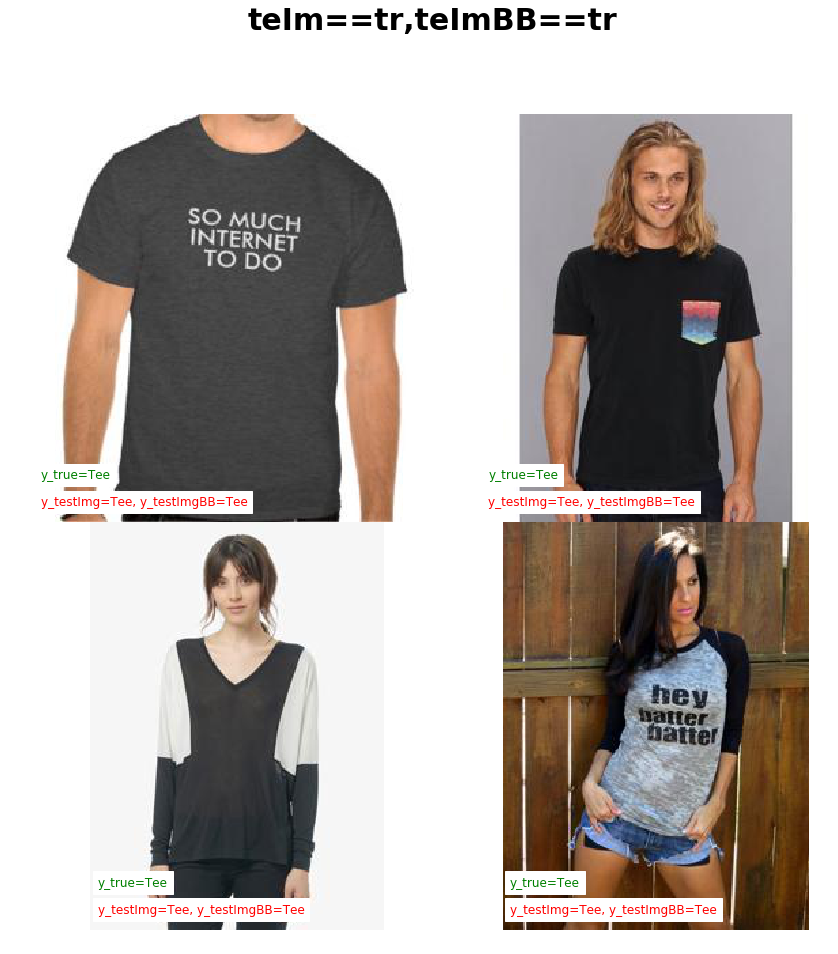

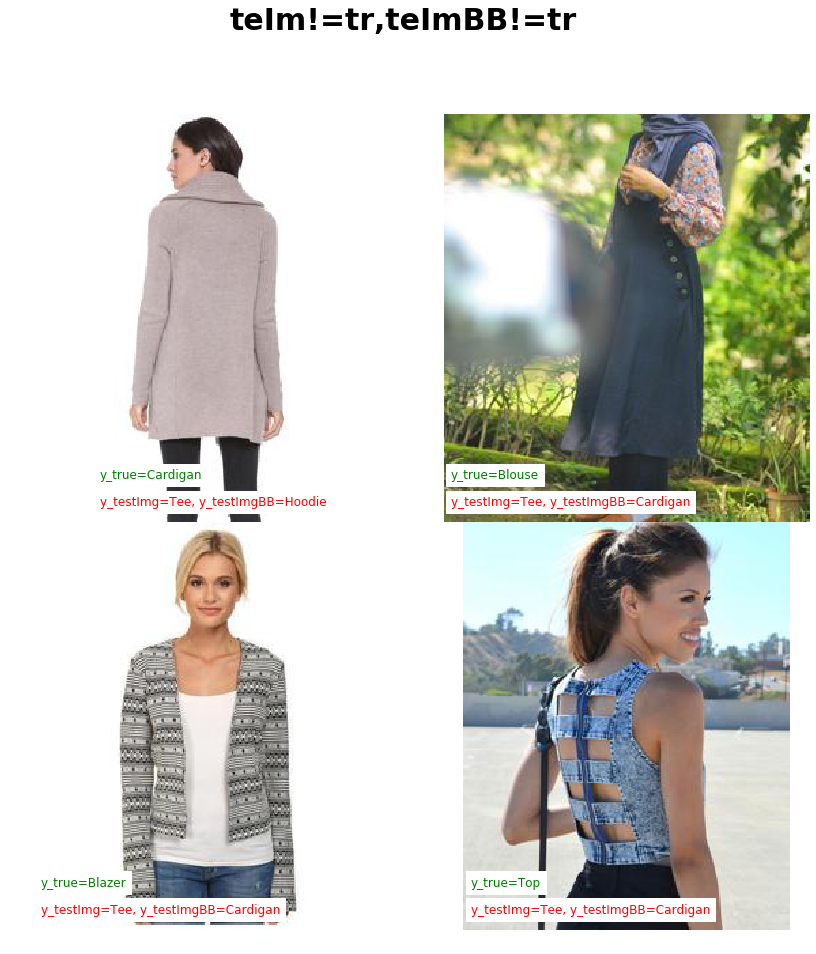

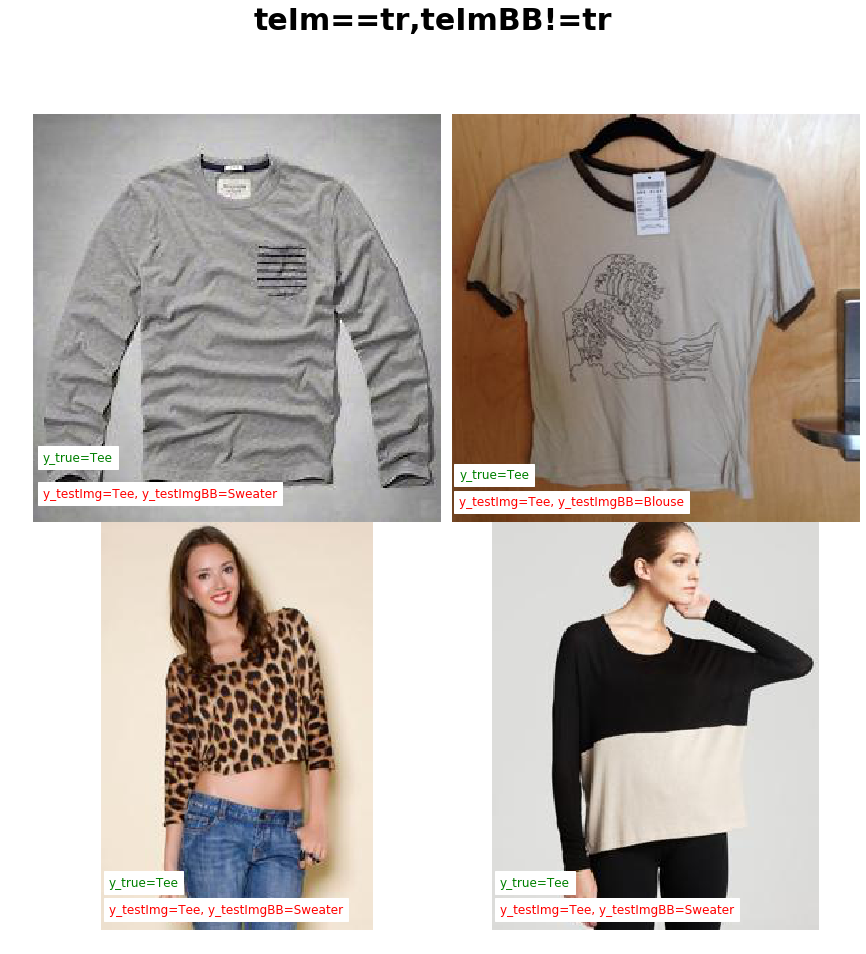

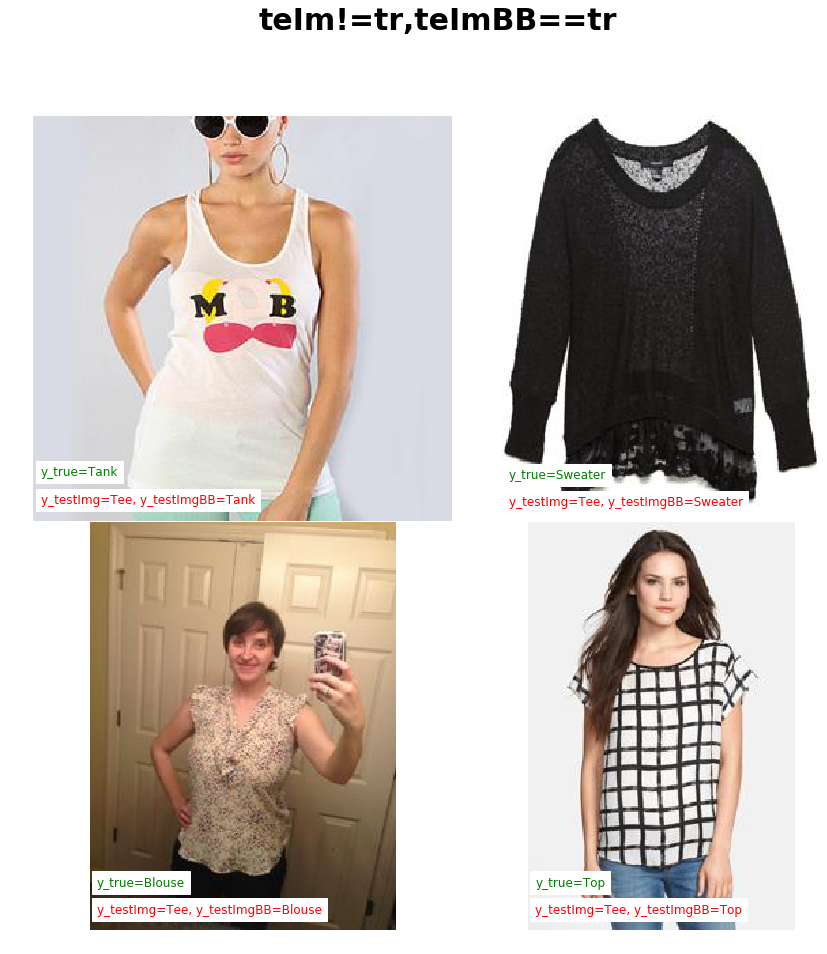

In [203]:
for testType,testFiles in testCaseFiles.items():
    pltShape = (2,2)
    fig = plt.figure(figsize=(15,15))
    ax = [plt.subplot(*pltShape,i+1) for i in range(selectSize)]
    plt.subplots_adjust(wspace=0,hspace=0)
    
    selectFiles=random.sample(testFiles,k=selectSize)
    
    for axi,imgf in zip(ax,selectFiles):
        y_true=y_trueImg[y_trueInd[imgf]]
        cl_y_true = clInd_name[np.argmax(y_true)]

        y_test_img = y_testImg[y_trueInd[imgf]]
        cl_y_test_img = clInd_name[np.argmax(y_test_img)]

        y_test_imgBB = y_testImgBB[y_trueInd[imgf]]
        cl_y_test_imgBB = clInd_name[np.argmax(y_test_imgBB)]

        axi.set_axis_off()
        img = plt.imread(os.path.join(valDataDir,imgf))
        h,w = img.shape[:2]
        axi.imshow(img)

        axi.annotate(f'y_true={cl_y_true}',xy=(5,h-40),
                     color='green',backgroundcolor='white',
                     fontsize=12,
                     verticalalignment='top',
                     horizontalalignment='left')

        axi.annotate(f'y_testImg={cl_y_test_img}, y_testImgBB={cl_y_test_imgBB}',xy=(5,h-20),
                 color='red',backgroundcolor='white',
                 fontsize=12,
                 verticalalignment='top',
                 horizontalalignment='left')

    plt.subplots_adjust(wspace=0,hspace=0)
    plt.suptitle(testType,fontsize=30,fontweight='bold')
    fnameOut = testType.replace('!=','NE').replace('==','EQ').replace(',','_')
    plt.savefig(f"./example_{fnameOut}.jpg",bbox_inches='tight')
    #fig.subplots_adjust(top=0.8)
    plt.show()  

In [202]:
img.shape[:2]

(160, 160)

In [128]:
testCaseFiles['uncaught'] = 0

In [130]:
testCaseFiles.pop('uncaught')

0

In [68]:
f = selectFiles[0]

In [84]:
cl_y_test

'Tee'

In [92]:
y_true=y_trueImg[y_trueInd[f]]

In [93]:
cl_y_true = clInd_name[np.argmax(y_true)]

In [94]:
cl_y_true

'Blouse'